In [1]:
import sys
try:
    del sys.modules["clg"]
except:
    pass
try:
    del sys.modules["spnhelp"]
except:
    pass
import spnhelp
from clg import noise, Norm
from math import sqrt
from spn.io.Text import spn_to_str_equation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spn.structure.Base import get_number_of_nodes, get_depth, Product
from spn.algorithms.Inference import likelihood
import scipy.stats as stats
from IPython.display import display

In [4]:
A = "A" @ (noise + 0.27)
B = "B" @ (A + 0.5*noise + 2)
C = "C" @ (-A + 0.5*noise - 1.5)
D = "D" @ (0.5*B + 0.5*C + 0.5*noise + 1)
# K = "K" @ (3*noise)
# A & K

# spn = spnhelp.clg_to_spn(A, sloped=True, crit_param=1)
param = 1.1
spn = spnhelp.clg_to_spn(A, sloped=True, crit_param=param, crit=spnhelp.CRIT_slopyform_bounded_ratio)
# spnhelp.plot_marginals(spn, A)

KeyboardInterrupt: 

In [ ]:
print(spnhelp.get_error_bounds(A, {n.name : param for n in A.get_nodes()}))

[1.05 1.05 1.05]
full evidence computation is off by a ratio of at most:  1.1576250000000001
depths {'A': 0, 'B': 1, 'C': 1}
ancestors {'A': set(), 'B': {'A'}, 'C': {'A'}}
defaultdict(<function get_error_bounds.<locals>.<lambda> at 0x000002233A2003A0>, {'A': 1.05, 'B': 1.1025, 'C': 1.1025})


     X    Y    Z    J
X  0.0  0.0  0.0  0.0
Y  0.0  0.0  0.0  0.0
Z  0.0  0.0  1.0  1.0
J  0.0  0.0  1.0  2.0


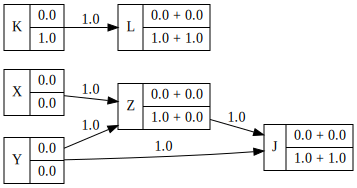

In [ ]:

W = "X" @ noise
X = "X" @ noise
Y = "Y" @ noise
Z = "Z" @ (X + Y + noise)
J = "J" @ (Z + noise + Y)

K = "K" @ noise
L = "L" @ (K + noise)

Z & L
X.condition(0)
Y.condition(0)
print(X.get_Σ())
# samples = X.forward_sample(10000)
# print(np.cov(samples, rowvar=False))
X.get_graph(True)

     X    Y    Z    J
X  1.0  0.0  1.0  1.0
Y  0.0  1.0  1.0  2.0
Z  1.0  1.0  3.0  4.0
J  1.0  2.0  4.0  7.0


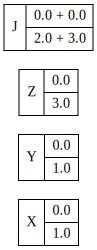

In [ ]:
copy = X.deepcopy()
copy.castrate_roots()

print(copy.get_Σ())
np.linalg.inv(copy.get_Σ())
copy.get_graph(True)

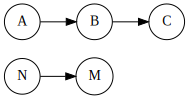

     A    B    C
A  1.0  1.0  1.0
B  1.0  2.0  2.0
C  1.0  2.0  3.0


TypeError: clg_to_spn() got an unexpected keyword argument 'eps'

In [ ]:
from itertools import product
from spn.structure.Base import Node, Sum, Product, assign_ids, rebuild_scopes_bottom_up



A = "A" @ noise
B = "B" @ (A + noise + 1)
# I = "I" @ noise
C = "C" @ (B + noise + 1)
# C = "C" @ (A + noise + 3)
# D = "D" @ (B + C + noise - 4)

N = "N" @ (noise - 3)
M = "M" @ (N + noise - 2)

A & N

display(A.get_graph())
print(A.get_Σ())

plt.rcParams["figure.figsize"] = (12, 6)
spn = spnhelp.clg_to_spn(A, eps = 2, sloped = True)
spnhelp.plot_marginals(spn, A)

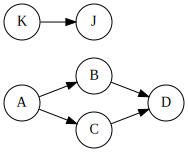

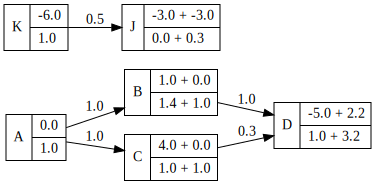

In [ ]:
A = "A" @ noise  # noise is an i.i.d. gaussian with mean 0 and variance 1. The @ operator assigns a name to the variable.
B = "B" @ (A + 1.2*noise + 1) # They can be composed with other variables, and more noise can be added.
C = "C" @ (A + noise + 4)
D = "D" @ (B + 0.3*C + noise - 5)

K = "K" @ (noise - 6)
J = "J" @ (0.5 * K - 3 + 0.2*noise)
A & K # Here, we join the two pgms, which have no connecting edges between them.
display(A.get_graph(detailed=False))
display(A.get_graph(detailed=True))

12631 nodes, with depth of 6


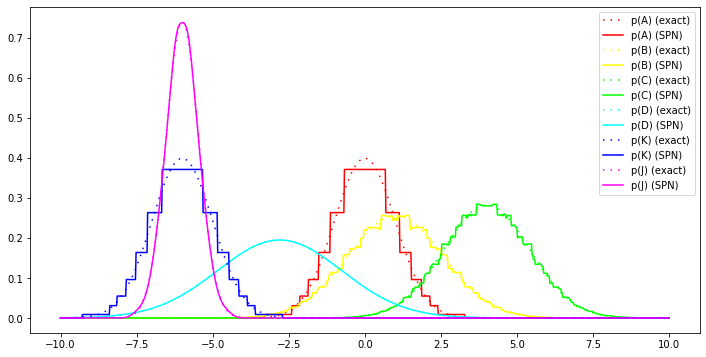

In [ ]:
spn = spnhelp.clg_to_spn(A, eps = 1.5)
spnhelp.plot_marginals(spn, A)
print(get_number_of_nodes(spn), "nodes, with depth of", get_depth(spn))

In [ ]:
scope = A.get_scope(across_factors=True)
print(K.get_Σ())
print(A.get_Σ())
samples = spnhelp.sample_from_spn(spn, 10000)
cov = np.cov(samples, rowvar=False).round(1)
print(pd.DataFrame(cov, index=scope, columns=scope))

     K     J
K  1.0  0.50
J  0.5  0.29
     A     B    C     D
A  1.0  1.00  1.0  1.30
B  1.0  2.44  1.0  2.74
C  1.0  1.00  2.0  1.60
D  1.3  2.74  1.6  4.22
     A    B    C    D    K    J
A  1.0  1.0  1.0  1.3 -0.0 -0.0
B  1.0  2.5  1.0  2.8 -0.0 -0.0
C  1.0  1.0  2.0  1.6 -0.0 -0.0
D  1.3  2.8  1.6  4.3 -0.0 -0.0
K -0.0 -0.0 -0.0 -0.0  1.0  0.5
J -0.0 -0.0 -0.0 -0.0  0.5  0.3


In [ ]:
scope = A.get_scope(across_factors=True)
print(K.get_µ())
print(A.get_µ())
samples = spnhelp.sample_from_spn(spn, 10000)
mean = np.mean(samples, axis=0).round(1)
print(pd.Series(mean, index=scope))

K   -6.0
J   -6.0
dtype: float64
A    0.0
B    1.0
C    4.0
D   -2.8
dtype: float64
A    0.0
B    1.0
C    4.0
D   -2.8
K   -6.0
J   -6.0
dtype: float64


[2105968645152, 2105968649952, 2105968655616, 2105968653360]
     A    B    C    D
A  1.0  1.0  1.0  1.0
B  1.0  2.0  2.0  2.0
C  1.0  2.0  3.0  3.0
D  1.0  2.0  3.0  4.0


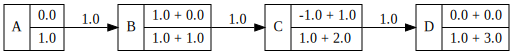

[2105968651056, 2105968652256, 2105968648416]
     B    C    D
B  2.0  2.0  2.0
C  2.0  3.0  3.0
D  2.0  3.0  4.0


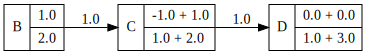

[2105968648032, 2105968645920]
     C    D
C  3.0  3.0
D  3.0  4.0


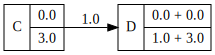

[2105968641744]
     D
D  4.0


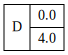

In [ ]:

A = "A" @ noise
"D" @ ("C" @ ("B" @ (A + noise + 1) + noise - 1) + noise)
# "C" @ (A + noise)
# "D" @ (A + noise)


B = A.deepcopy().castrate_roots()
C = B.deepcopy().castrate_roots()
D = C.deepcopy().castrate_roots()

for x in [A, B, C, D]:
    print(list(map(lambda n: id(n) , x.get_nodes())))
    print(x.get_Σ())
    display(x.get_graph(True))

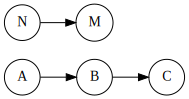

     A    B    C
A  1.0  1.0  1.0
B  1.0  2.0  2.0
C  1.0  2.0  3.0
1323 nodes, with depth of 6
243 nodes, with depth of 6


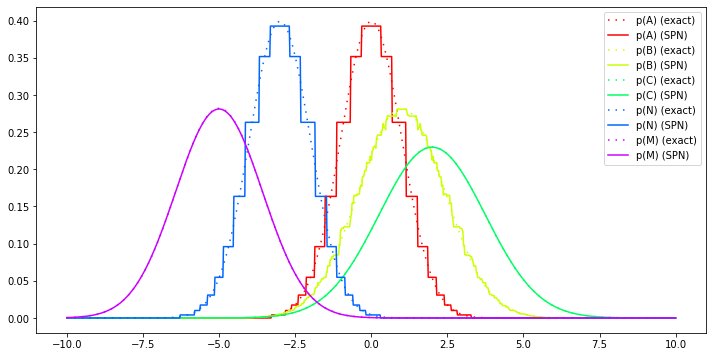

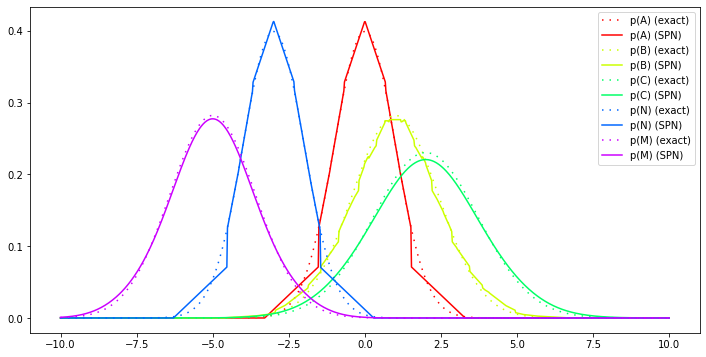

In [ ]:
from itertools import product
from spn.structure.Base import Node, Sum, Product, assign_ids, rebuild_scopes_bottom_up


A = "A" @ noise
B = "B" @ (A + noise + 1)
# I = "I" @ noise
C = "C" @ (B + noise + 1)
# C = "C" @ (A + noise + 3)
# D = "D" @ (B + C + noise - 4)

N = "N" @ (noise - 3)
M = "M" @ (N + noise - 2)

A & N

display(A.get_graph())
print(A.get_Σ())

spn = spnhelp.clg_to_spn(A, eps = 0.5)
sloped_spn = spnhelp.clg_to_spn(A, eps = 2.0, sloped=True)
spnhelp.plot_marginals(spn, A)
spnhelp.plot_marginals(sloped_spn, A)
print(get_number_of_nodes(spn), "nodes, with depth of", get_depth(spn))
print(get_number_of_nodes(sloped_spn), "nodes, with depth of", get_depth(sloped_spn))